In [51]:
# Import library used in the notebooks (Run first)
import os
import Augmentor
import zipfile
import random
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
#SKIP THIS Unzip data set 
local_zip = 'Discoloration.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('Dataset/')
zip_ref.close()

local_zip2 = 'Periodontal.zip'
zip_ref2    = zipfile.ZipFile(local_zip2, 'r')
zip_ref2.extractall('Dataset/') 
zip_ref2.close()

In [73]:
#SKIP THIS
print(len(os.listdir('Dataset/Discoloration')))
print(len(os.listdir('Dataset/Periodontal')))
print(len(os.listdir('Dataset/Healthy')))

1000
1000
1000


In [2]:
#SKIP THIS
def AugmentData(source_dir, count):
    source_dir = source_dir
    output_dir = "."
    p = Augmentor.Pipeline(source_directory=source_dir, output_directory=output_dir)
    #p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)
    p.rotate(probability=0.001, max_left_rotation=0.001, max_right_rotation=0.001)
    #p.zoom_random(probability=0.5, percentage_area=0.9)
    #p.crop_random(probability=0.6, percentage_area=0.9)
    #p.resize(probability=1.0, width=64, height=64)
    p.sample(count)

In [275]:
#SKIP THIS
AugmentData("Dataset/Discoloration/", 1000)
AugmentData("Dataset/Periodontal/", 1000)
AugmentData("Dataset/Healthy/", 1000)

Initialised with 70 image(s) found.
Output directory set to Dataset/Healthy/..

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x402 at 0x1A6ED87E4C0>: 100%|█| 1000/1000 [00:01<0


In [276]:
#SKIP THIS
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


Discoloration_SOURCE_DIR = "Dataset/Discoloration/"
Periodontal_SOURCE_DIR = "Dataset/Periodontal/"
Healthy_SOURCE_DIR = "Dataset/Healthy/"

TRAINING_Discoloration_DIR = "Dataset_Real/training/Dental Discoloration/"
TRAINING_Periodontal_DIR = "Dataset_Real/training/Periodontal/"
TRAINING_Healthy_DIR = "Dataset_Real/training/Healthy/"

TESTING_Discoloration_DIR = "Dataset_Real/testing/Dental Discoloration/"
TESTING_Periodontal_DIR = "Dataset_Real/testing/Periodontal/"
TESTING_Healthy_DIR = "Dataset_Real/testing/Healthy/"

split_size = .8
split_data(Discoloration_SOURCE_DIR, TRAINING_Discoloration_DIR, TESTING_Discoloration_DIR, split_size)
split_data(Periodontal_SOURCE_DIR, TRAINING_Periodontal_DIR, TESTING_Periodontal_DIR, split_size)
split_data(Healthy_SOURCE_DIR, TRAINING_Healthy_DIR, TESTING_Healthy_DIR, split_size)

In [370]:
#Augment the dataset and initialize the test and validation generator (Run Second) 
TRAINING_DIR = "Dataset_Real/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = "Dataset_Real/testing/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=20,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [2]:
#Check the train generator 
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

NameError: name 'train_generator' is not defined

In [372]:
#Prepare the generator data type (Run third)
dim = (150, 150)
channel = (3, )
input_shape = dim + channel

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, input_shape)
validation_data = tf_data_generator(validation_generator, input_shape)

In [468]:
#Initialize the model architecture used (Run forth)
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    #tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The forth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    tf.keras.layers.Dropout(0.3),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(126, activation='relu'),
    ##tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 150, 150, 32)      896       
                                                                 
 conv2d_125 (Conv2D)         (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 75, 75, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_126 (Conv2D)         (None, 73, 73, 64)        18496     
                                                                 
 conv2d_127 (Conv2D)         (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_110 (MaxPooli  (None, 35, 35, 64)       0         
 ng2D)                                               

In [469]:
# Set the training parameters (Run fifth)
model.compile(loss = 'categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [95]:
# SKIP THIS Mencari learning rate optimal
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [470]:
# Start the training process (Run sixth and last)
history = model.fit(train_data,
                    steps_per_epoch=75,
                    epochs=15,
                    validation_data=validation_data,
                    validation_steps=30,
                    shuffle=True,
                    verbose=2)

Epoch 1/15
75/75 - 29s - loss: 0.9530 - accuracy: 0.5367 - val_loss: 0.7196 - val_accuracy: 0.7117 - 29s/epoch - 380ms/step
Epoch 2/15
75/75 - 21s - loss: 0.6852 - accuracy: 0.7046 - val_loss: 0.5429 - val_accuracy: 0.7683 - 21s/epoch - 286ms/step
Epoch 3/15
75/75 - 20s - loss: 0.5400 - accuracy: 0.7688 - val_loss: 0.4137 - val_accuracy: 0.8317 - 20s/epoch - 261ms/step
Epoch 4/15
75/75 - 20s - loss: 0.3626 - accuracy: 0.8571 - val_loss: 0.3928 - val_accuracy: 0.8350 - 20s/epoch - 263ms/step
Epoch 5/15
75/75 - 20s - loss: 0.3618 - accuracy: 0.8446 - val_loss: 0.2979 - val_accuracy: 0.8850 - 20s/epoch - 263ms/step
Epoch 6/15
75/75 - 20s - loss: 0.2510 - accuracy: 0.9050 - val_loss: 0.2634 - val_accuracy: 0.8850 - 20s/epoch - 263ms/step
Epoch 7/15
75/75 - 20s - loss: 0.1982 - accuracy: 0.9200 - val_loss: 0.1608 - val_accuracy: 0.9317 - 20s/epoch - 260ms/step
Epoch 8/15
75/75 - 20s - loss: 0.2075 - accuracy: 0.9192 - val_loss: 0.2671 - val_accuracy: 0.8933 - 20s/epoch - 263ms/step
Epoch 9/

In [471]:
# Evalute the model
model.evaluate(validation_generator)

30/30 [==============================] - 4s 113ms/step - loss: 0.1234 - accuracy: 0.9567


[0.1233643963932991, 0.9566666483879089]

(0.0001, 0.001, 0.0, 1.0)

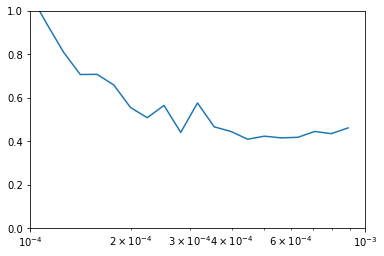

In [72]:
#SKIP THIS
lrs = 1e-4 * (10 ** (np.arange(20) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-4, 1e-3, 0, 1])

In [212]:
#SET the class 
class_names =  ["Discloration", "Healthy", "Periodontal"]
for i in range(len(class_names)):
    print(class_names[i] ," " , i)

Discloration   0
Healthy   1
Periodontal   2


In [215]:
#Test the model
import numpy as np
from keras.preprocessing import image

path = "1.jpg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

[[1.1075938e-03 2.5811791e-05 9.9886668e-01]]


[[4.1475791e-06 9.9998915e-01 6.6316193e-06]]
[1]
Healthy


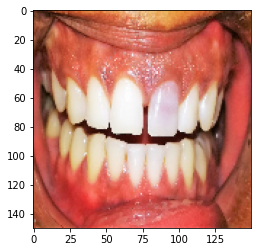

In [508]:
import matplotlib.pyplot as plt

image_path = "12.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)/255
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
print(prediction)
prediction = np.argmax(prediction,axis=1)
print(prediction)
print(class_names[prediction[0]])
plt.imshow(new_img)

C:\Users\Legion\AppData\Local\Temp\ipykernel_30320\3682960999.py:57: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


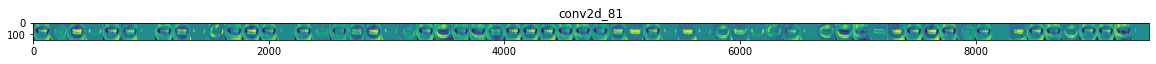

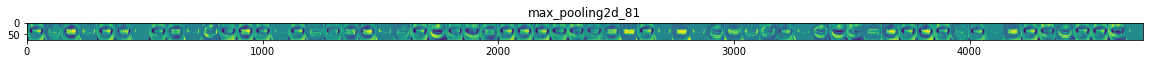

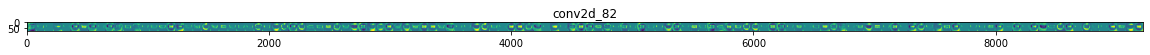

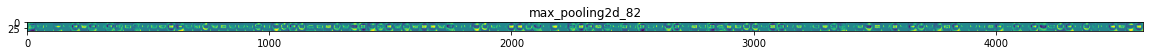

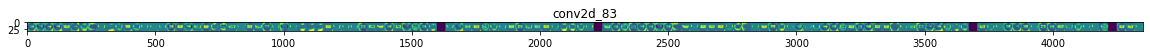

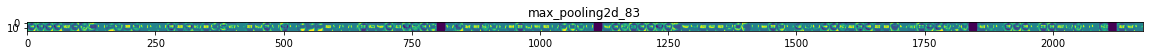

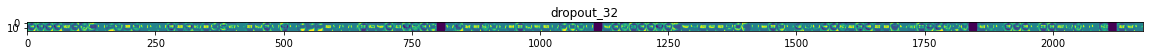

In [338]:
# SKIP THIS use to chech the convolutional of the layer
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
base_dir = 'Dataset_Real'
train_dir = os.path.join(base_dir, 'training')

train_Dental_Discoloration_dir = os.path.join(train_dir, 'Dental Discoloration')
train_Healthy_dir = os.path.join(train_dir, 'Healthy')

train_Dental_Discoloration_fnames = os.listdir( train_Dental_Discoloration_dir )
train_Healthy_fnames = os.listdir( train_Healthy_dir )


# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
Dental_Discoloration_img_files = [os.path.join(train_Dental_Discoloration_dir, f) for f in train_Dental_Discoloration_fnames]
Healthy_img_files = [os.path.join(train_Healthy_dir, f) for f in train_Healthy_fnames]
img_path = random.choice(Dental_Discoloration_img_files + Healthy_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 


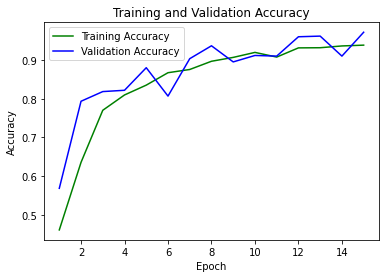

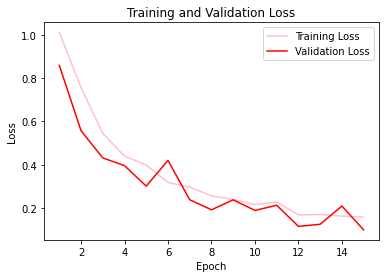

In [343]:
#Plotting training values to check the model performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [1]:
#Convert the model into Tensorflow lite format
export_dir = 'saved_model/1/'
tf.save(model, export_dir)

NameError: name 'tf' is not defined

In [38]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [42]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

39310376

In [45]:
#Test the tflite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [46]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [52]:
image_path = "1.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()
rflite_results = interpreter.get_tensor(output_details[0]['index'])

In [53]:
print(rflite_results)

[[1. 0. 0.]]


In [200]:
print(input_details)
print(output_details)

[{'name': 'serving_default_conv2d_15_input:0', 'index': 0, 'shape': array([  1, 150, 150,   3]), 'shape_signature': array([ -1, 150, 150,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 24, 'shape': array([1, 3]), 'shape_signature': array([-1,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


[0.25552574 0.742077   0.00239725]
Prediksi : Healthy
Persentase Keyakinan : 74.21 %

Prediksi : Discloration
Persentase Keyakinan : 25.55 %
Prediksi : Healthy
Persentase Keyakinan : 74.21 %
Prediksi : Periodontal
Persentase Keyakinan : 0.24 %


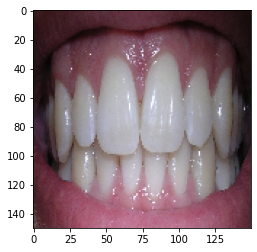

In [199]:
#Test the finished model

path = "2.jpg"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
prediction = np.argmax(classes,axis=1)
print(classes[0])

print("Prediksi : {}".format(class_names[prediction[0]]))
print("Persentase Keyakinan : {:.2f} %\n".format(np.max(classes) * 100))

for i in range(len(class_names)):
    print("Prediksi : {}".format(class_names[i]))
    print("Persentase Keyakinan : {:.2f} %".format(classes[0][i] * 100))  
          
plt.imshow(img)

[[1. 0. 0.]]
[0]
Discloration


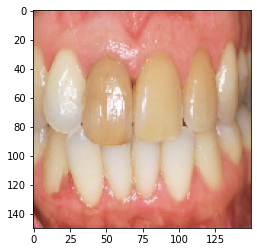

In [156]:
import matplotlib.pyplot as plt

image_path = "8.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
print(prediction)
prediction = np.argmax(prediction,axis=1)
print(prediction)
print(class_names[prediction[0]])
plt.imshow(new_img)